# Самостоятельный проект: Сборный проект —2

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Описание задачи

Общий анализ компании «Работа с заботой» и разработатку решения, которое позволит остановить отток персонала из компании.

### Цель задачи

Разработать модель для предсказания уровеня удовлетворённости сотрудника на основе данных заказчика

### Описание данных

Данные содержат 3 Датафрейма с информацией о сотрудниках.

### План работы

1. Загрузка и изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных
5. Обучение моделей
6. Оформление выводов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from phik.phik import phik_matrix

### Загрузка данных

In [2]:
#анализируем 1 набор данных
filepath = r"C:\Users\erofe\Downloads\train_job_satisfaction_rate.csv"
df_train = pd.read_csv(filepath, sep=',')

In [3]:
#ищем дубликаты
print(df_train.duplicated().sum())

0


In [4]:
#выводим первые 10 строк таблицы
print(df_train.head(10))
#выводим информацию о таблице
print(df_train.info())

       id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   
5  405448          hr  middle      low                 7              no   
6  857135       sales  sinior   medium                 9              no   
7  400657  purchasing  middle     high                 9              no   
8  198846          hr  junior      low                 1              no   
9  149797  technology  middle     high                 6              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1    

In [5]:
#Проверяем данные на неявные дубликаты
print(df_train['dept'].unique())
print(df_train['level'].unique())
print(df_train['workload'].unique())
print(df_train['last_year_promo'].unique())
print(df_train['last_year_violations'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


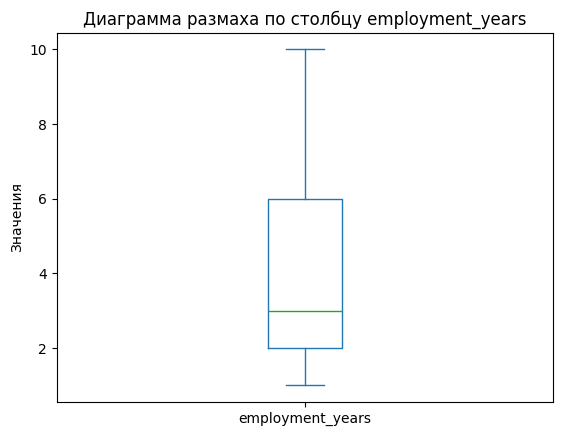

In [6]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df_train['employment_years'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу employment_years', ylabel = 'Значения')
plt.show()

Выбросов нет

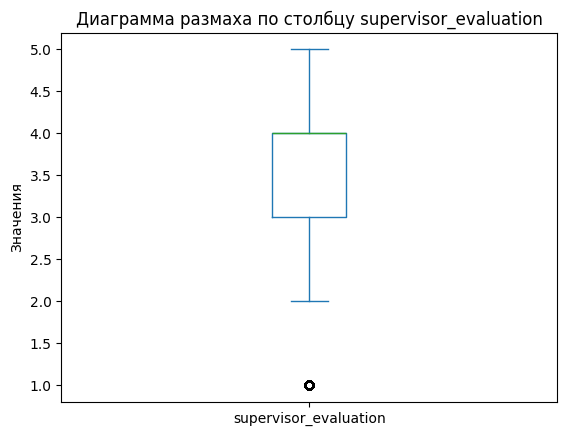

In [7]:
df_train['supervisor_evaluation'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу supervisor_evaluation', ylabel = 'Значения')
plt.show()

Выбросы разумны, удалять не стоит.

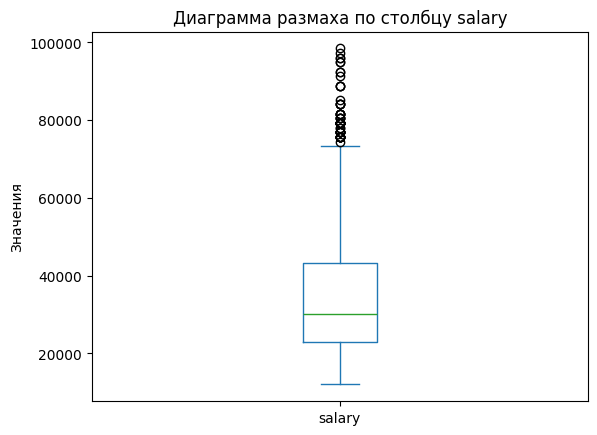

In [8]:
df_train['salary'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу salary', ylabel = 'Значения')
plt.show()

Выбросы разумны, удалять не стоит.

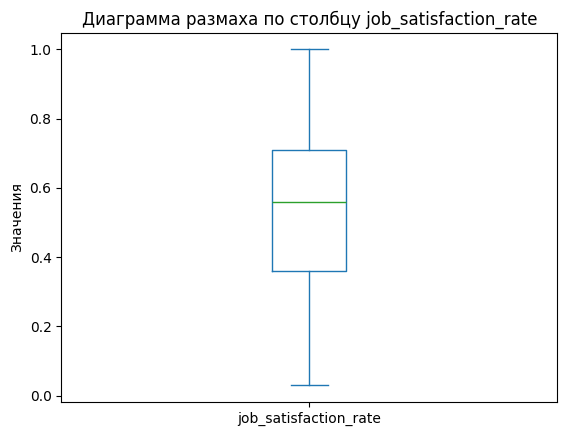

In [9]:
df_train['job_satisfaction_rate'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу job_satisfaction_rate', ylabel = 'Значения')
plt.show()

Выбросов нет

С данными все отлично, кроме пропущенных значений, которые будут устранены на этапе с пайплайнами.

In [10]:
#анализируем 2 набор данных
filepath = r"C:\Users\erofe\Downloads\test_features.csv"
df_x = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_x.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_x.head(10))
#выводим информацию о таблице
print(df_x.info())

0
       id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   3

In [11]:
#Проверяем данные на неявные дубликаты
print(df_x['dept'].unique())
print(df_x['level'].unique())
print(df_x['workload'].unique())
print(df_x['last_year_promo'].unique())
print(df_x['last_year_violations'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


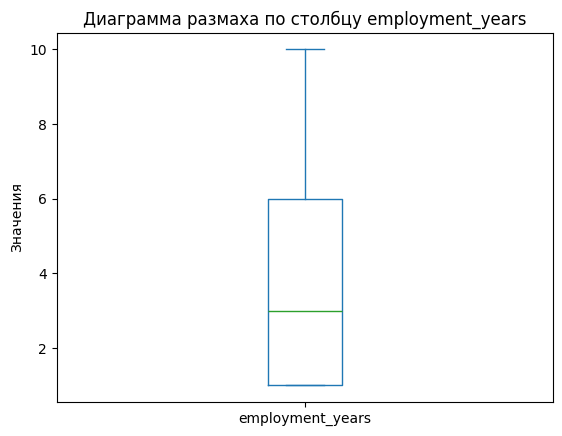

In [12]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df_x['employment_years'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу employment_years', ylabel = 'Значения')
plt.show()

Выбросов нет

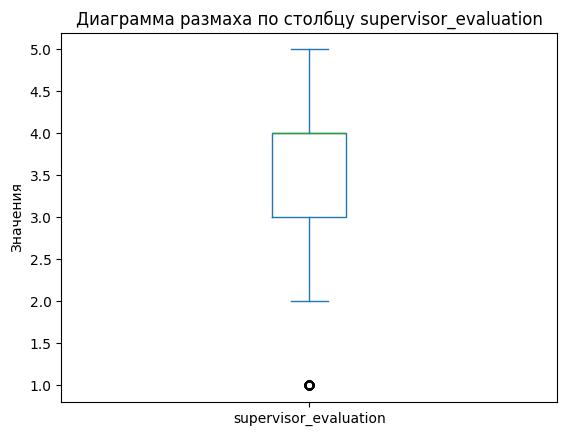

In [13]:
df_x['supervisor_evaluation'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу supervisor_evaluation', ylabel = 'Значения')
plt.show()

Выбросы разумны, удалять не стоит.

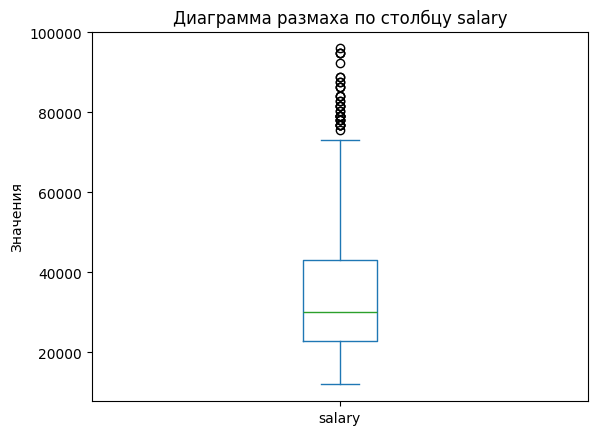

In [14]:
df_x['salary'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу salary', ylabel = 'Значения')
plt.show()

Выбросы разумны, удалять не стоит.

С данными все отлично, кроме пропущенных значений, которые будут устранены на этапе с пайплайнами. Так же есть строки с пробелами, которые будут заменены в этапе предобработки на пропущенные значения.

In [15]:
#анализируем 3 набор данных
filepath = r"C:\Users\erofe\Downloads\test_target_job_satisfaction_rate.csv"
df_y = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_y.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_y.head(10))
#выводим информацию о таблице
print(df_y.info())

0
       id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08
5  817219                   0.76
6  269033                   0.64
7  962356                   0.38
8  649052                   0.14
9  532834                   0.59
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


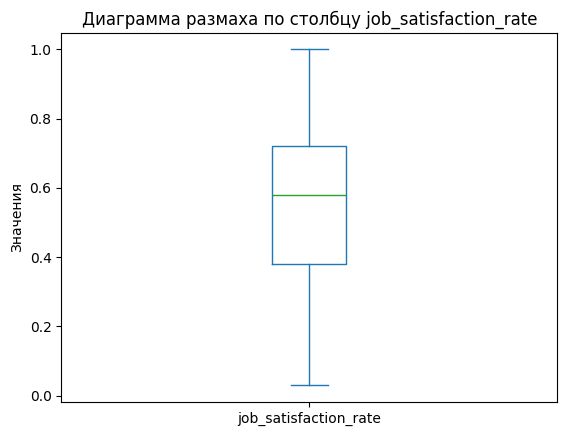

In [16]:
df_y['job_satisfaction_rate'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу job_satisfaction_rate', ylabel = 'Значения')
plt.show()

Выбросов нет

С данными все отлично

Вывод: В 1 и 2 датафрейме были найдены пропущенные значения, которые будут устранены на этапе с пайплайнами. Во 2 датафрейме были найдены пропущенные строки, что будет устранено в предобработке.

### Предобработка данных

In [17]:
# Замена пробелов на NaN
df_x['dept'] = df_x['dept'].replace(' ', np.nan)
df_x['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [18]:
df_x['workload'] = df_x['workload'].replace(' ', np.nan)
df_x['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

Вывод: В предобработке данных мы заменили пробелы на пропущенные значения, все эти значения будут устранены на этапе с пайплайнами

### Исследовательский анализ данных

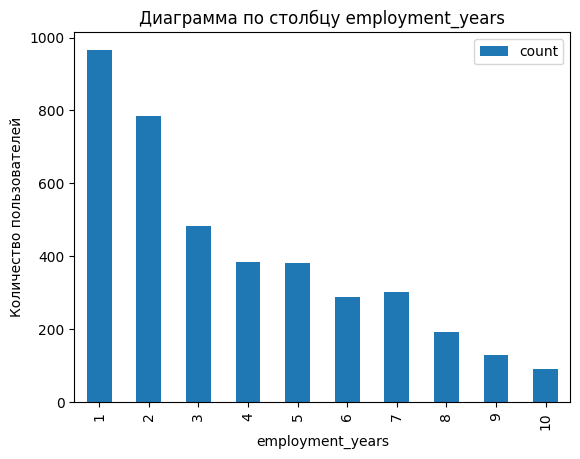

In [19]:
#Проводим анализ всех имеющихся признаков
bar_sorted = df_train['employment_years'].value_counts().reset_index()
bar_sorted.columns = ['employment_years', 'count']
bar_sorted = bar_sorted.sort_values(by = 'employment_years')
bar_sorted.plot(kind = 'bar', x = 'employment_years', y = 'count', title = 'Диаграмма по столбцу employment_years')
plt.xlabel('employment_years')
plt.ylabel('Количество пользователей')
plt.show()

В компании достаточно мало людей, работающих долгое время, и чем дальше, тем их количество уменьшается, что плохой знак.

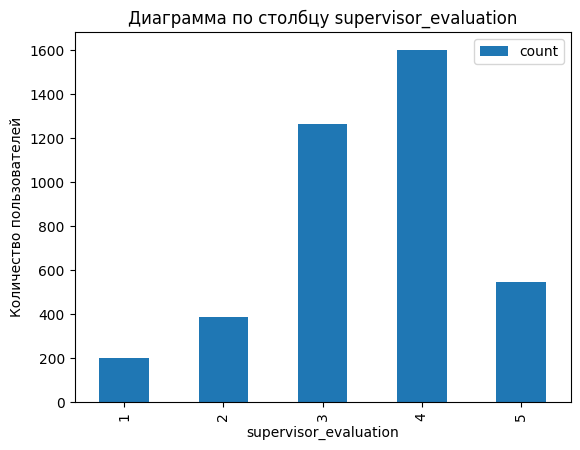

In [20]:
bar_sorted = df_train['supervisor_evaluation'].value_counts().reset_index()
bar_sorted.columns = ['supervisor_evaluation', 'count']
bar_sorted = bar_sorted.sort_values(by = 'supervisor_evaluation')
bar_sorted.plot(kind = 'bar', x = 'supervisor_evaluation', y = 'count', title = 'Диаграмма по столбцу supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('Количество пользователей')
plt.show()

Достаточно мало людей, работающих на 5 из 5, в основном, все работают на 3, 4.

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

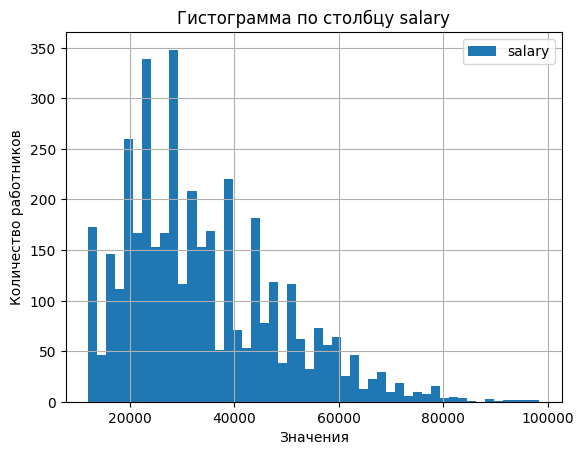

In [21]:
df_train.plot(y = 'salary', kind = 'hist', bins = 50, grid=True, title = 'Гистограмма по столбцу salary')
plt.xlabel('Значения')
plt.ylabel('Количество работников')
df_train['salary'].describe()

Среднее значение - 33926.700000. Распределение нормальное.

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

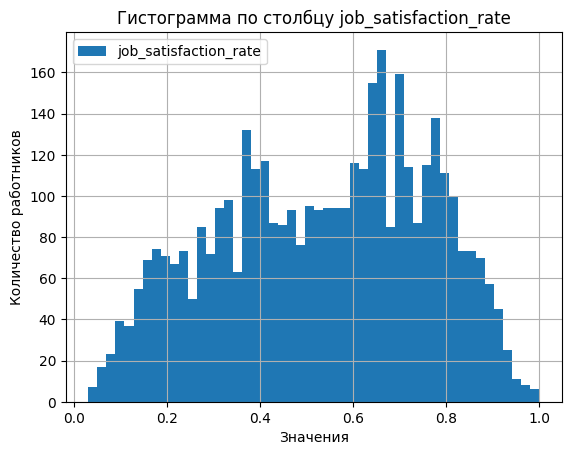

In [22]:
df_train.plot(y = 'job_satisfaction_rate', kind = 'hist', bins = 50, grid=True, title = 'Гистограмма по столбцу job_satisfaction_rate')
plt.xlabel('Значения')
plt.ylabel('Количество работников')
df_train['job_satisfaction_rate'].describe()

Распределение нормальное, но очень большой процент сотрудников не удовлетворены своей работой, что плохо для компании.

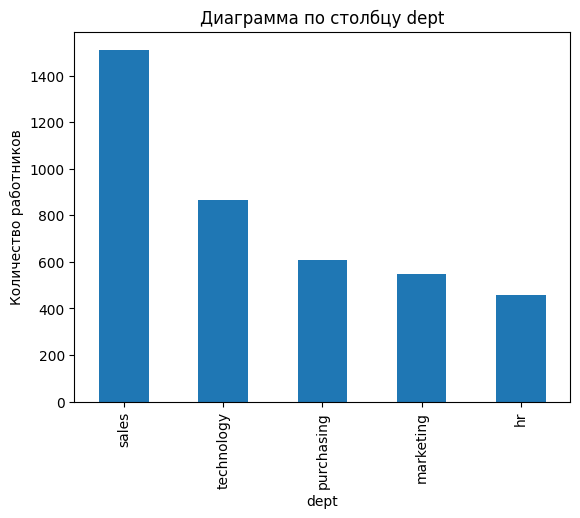

In [23]:
df_train['dept'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу dept')
plt.xlabel('dept')
plt.ylabel('Количество работников')
plt.show()

Больше всего людей работают в продажах. Меньше всего - в hr. 

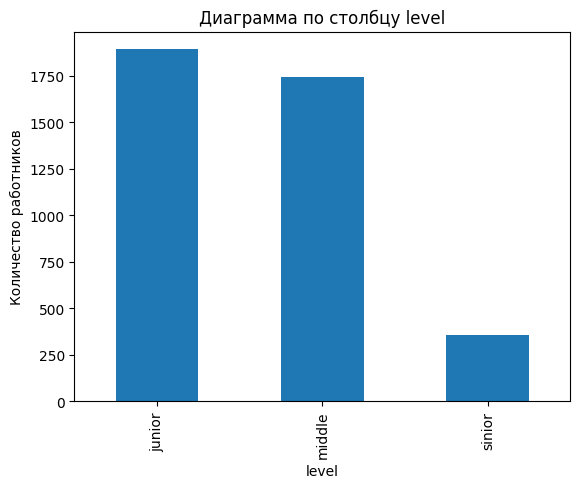

In [24]:
df_train['level'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу level')
plt.xlabel('level')
plt.ylabel('Количество работников')
plt.show()

Данные логичны, больше всего junior, далее middle, меньше всего sinior.

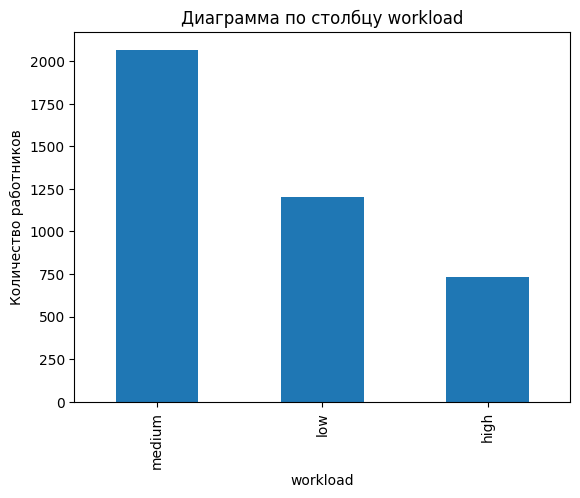

In [25]:
df_train['workload'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу workload')
plt.xlabel('workload')
plt.ylabel('Количество работников')
plt.show()

Данные логичны, большинство сотрудников средне нагруженно, правда пугает такой большой процент легко нагруженных работников.

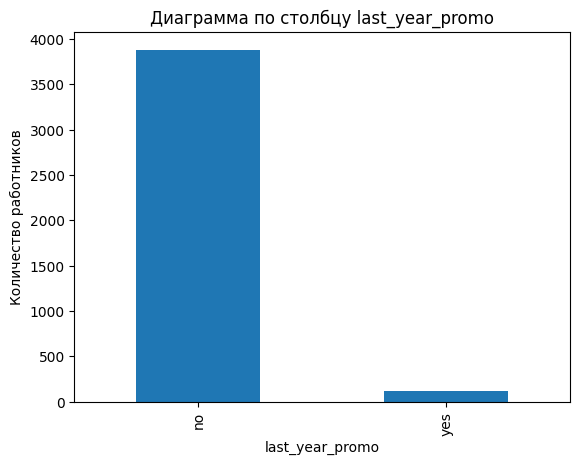

In [26]:
df_train['last_year_promo'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу last_year_promo')
plt.xlabel('last_year_promo')
plt.ylabel('Количество работников')
plt.show()

Болльшинство сотрудников не получали повышение в прошлом году, что и логично.

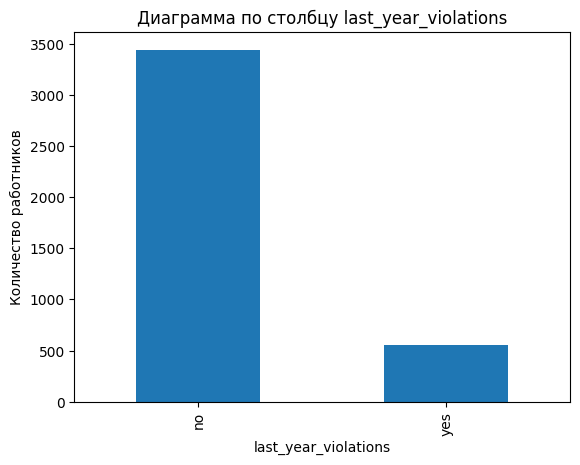

In [27]:
df_train['last_year_violations'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу last_year_violations')
plt.xlabel('last_year_violations')
plt.ylabel('Количество работников')
plt.show()

Достаточно много сотрудников в прошлом году, нарушали трудовой договор, это плохой знак.

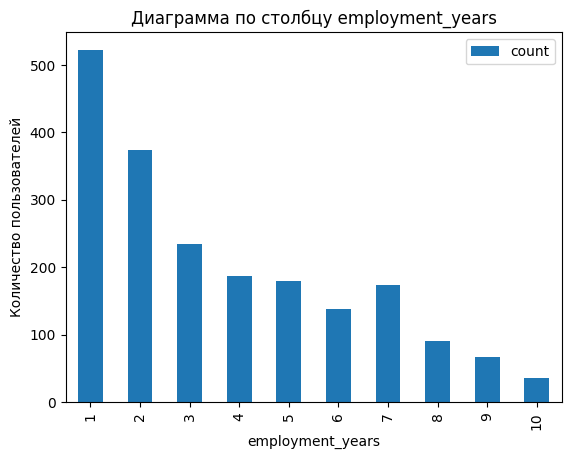

In [28]:
bar_sorted = df_x['employment_years'].value_counts().reset_index()
bar_sorted.columns = ['employment_years', 'count']
bar_sorted = bar_sorted.sort_values(by = 'employment_years')
bar_sorted.plot(kind = 'bar', x = 'employment_years', y = 'count', title = 'Диаграмма по столбцу employment_years')
plt.xlabel('employment_years')
plt.ylabel('Количество пользователей')
plt.show()

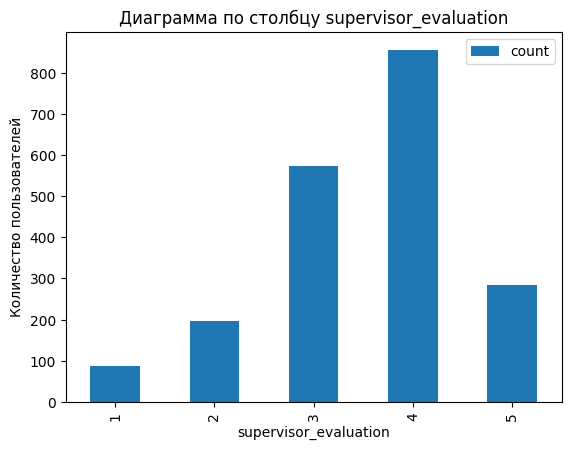

In [29]:
bar_sorted = df_x['supervisor_evaluation'].value_counts().reset_index()
bar_sorted.columns = ['supervisor_evaluation', 'count']
bar_sorted = bar_sorted.sort_values(by = 'supervisor_evaluation')
bar_sorted.plot(kind = 'bar', x = 'supervisor_evaluation', y = 'count', title = 'Диаграмма по столбцу supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('Количество пользователей')
plt.show()

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

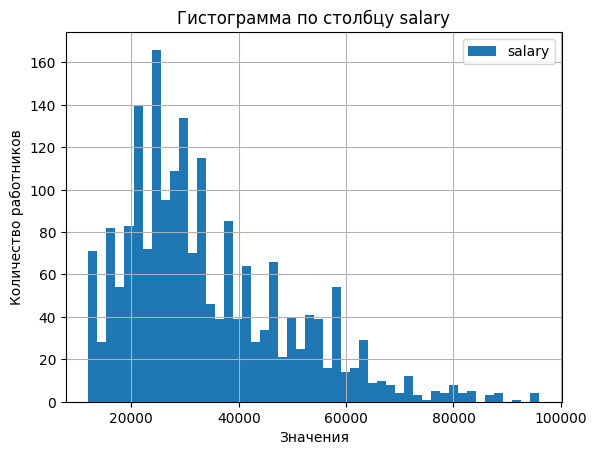

In [30]:
df_x.plot(y = 'salary', kind = 'hist', bins = 50, grid=True, title = 'Гистограмма по столбцу salary')
plt.xlabel('Значения')
plt.ylabel('Количество работников')
df_x['salary'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

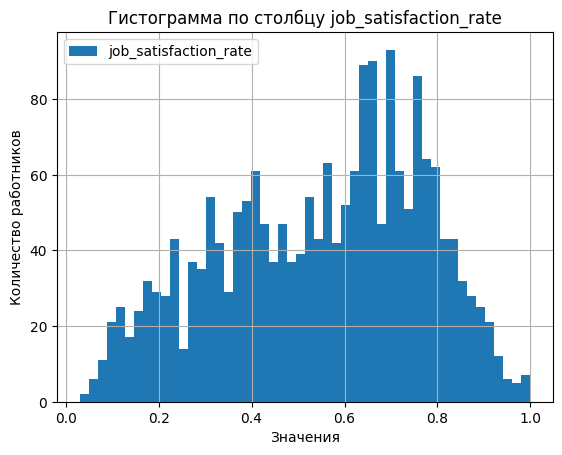

In [31]:
df_y.plot(y = 'job_satisfaction_rate', kind = 'hist', bins = 50, grid=True, title = 'Гистограмма по столбцу job_satisfaction_rate')
plt.xlabel('Значения')
plt.ylabel('Количество работников')
df_y['job_satisfaction_rate'].describe()

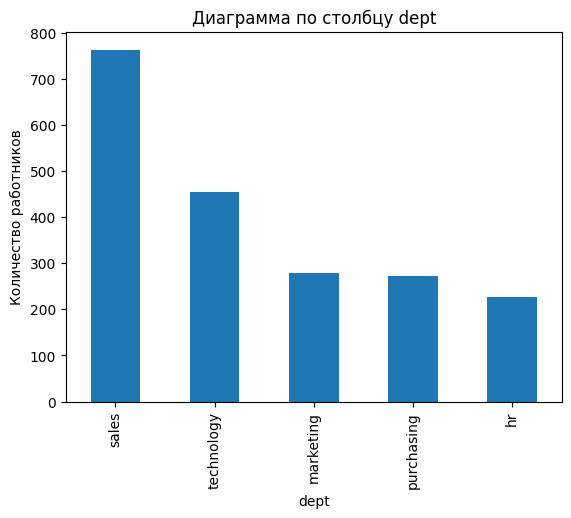

In [32]:
df_x['dept'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу dept')
plt.xlabel('dept')
plt.ylabel('Количество работников')
plt.show()

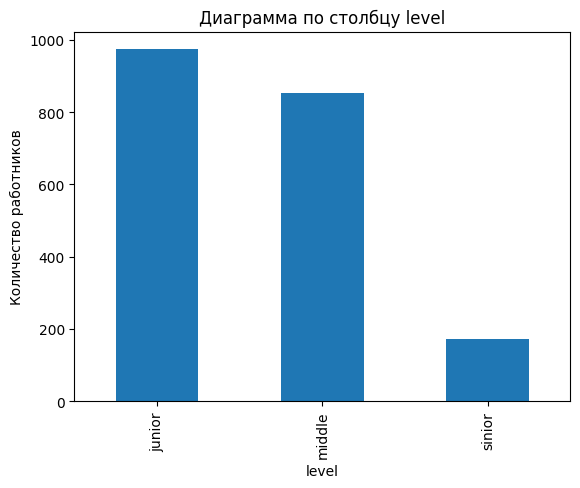

In [33]:
df_x['level'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу level')
plt.xlabel('level')
plt.ylabel('Количество работников')
plt.show()

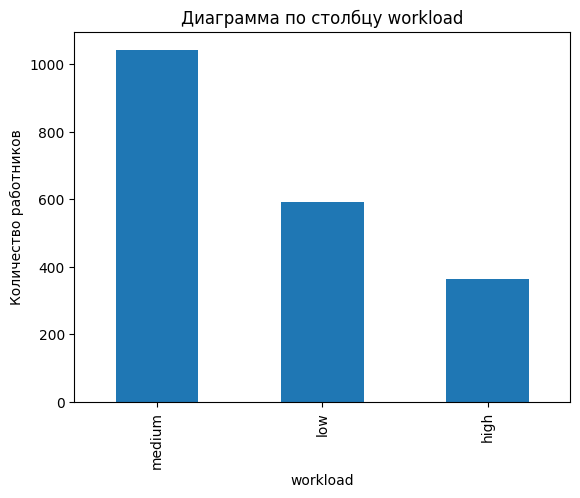

In [34]:
df_x['workload'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу workload')
plt.xlabel('workload')
plt.ylabel('Количество работников')
plt.show()

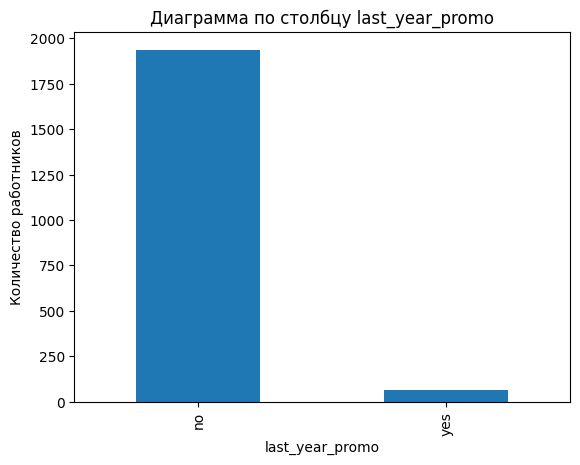

In [35]:
df_x['last_year_promo'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу last_year_promo')
plt.xlabel('last_year_promo')
plt.ylabel('Количество работников')
plt.show()

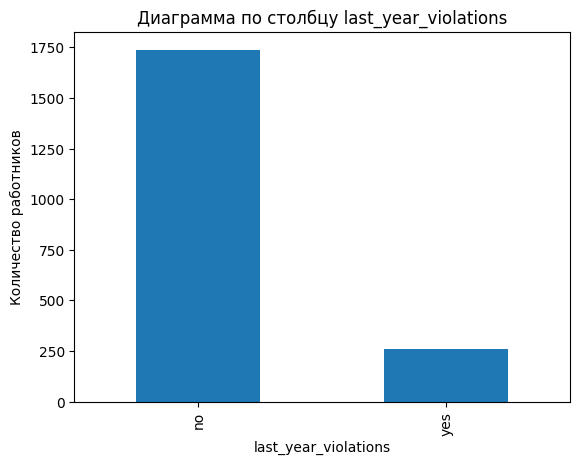

In [36]:
df_x['last_year_violations'].value_counts().plot(kind = 'bar', title = 'Диаграмма по столбцу last_year_violations')
plt.xlabel('last_year_violations')
plt.ylabel('Количество работников')
plt.show()

Данные тестовой выборки практически не отличаются от тренировочной. 

Вывод: В данной части проекта мы провели исследовательский анализ данных со всеми признаками (выводы по каждому признаку есть под графиками).

###  Подготовка данных и обучение модели

In [37]:
df_train = df_train.set_index('id')
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

In [38]:
#Строим матрицу phik
phik_matrix(df_train, interval_cols = ['salary', 'job_satisfaction_rate'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.018079,0.025931,0.000000,0.000000,0.100579,0.270239,0.074739
level,0.000000,1.000000,0.404459,0.675467,0.100352,0.000000,0.000000,0.714411,0.077260
workload,0.018079,0.404459,1.000000,0.165879,0.057938,0.000000,0.037565,0.785277,0.043958
employment_years,0.025931,0.675467,0.165879,1.000000,0.180832,0.043766,0.000000,0.469992,0.319331
last_year_promo,0.000000,0.100352,0.057938,0.180832,1.000000,0.011274,0.016247,0.211173,0.191464
last_year_violations,0.000000,0.000000,0.000000,0.043766,0.011274,1.000000,0.183221,0.000000,0.566993
supervisor_evaluation,0.100579,0.000000,0.037565,0.000000,0.016247,0.183221,1.000000,0.000000,0.762964
salary,0.270239,0.714411,0.785277,0.469992,0.211173,0.000000,0.000000,1.000000,0.149599
job_satisfaction_rate,0.074739,0.077260,0.043958,0.319331,0.191464,0.566993,0.762964,0.149599,1.000000


Мультиколлинеарности не обнаружено. Больше всего с целевым признаком коррелирует уровень оценки работника.

In [39]:
#Строим функцию для smape
def smape(y_true, y_pred):
    error = 2 * np.abs(y_pred - y_true)
    scale = np.abs(y_pred) + np.abs(y_true)
    return np.mean(error / scale) * 100
smape_scorer = make_scorer(smape, greater_is_better=False)

In [40]:
# Разделяем данные на признаки и целевую переменную
X = df_train.drop(['job_satisfaction_rate'], axis=1)
y = df_train['job_satisfaction_rate']

# Определение количественных и категориальных признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание трансформатора для категориальных данных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [41]:
# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [42]:
# Создание пайплайна предварительной обработки данных и поиска лучшей модели
# Для каждой модели добавим GridSearchCV для подбора гиперпараметра
regression_models = {
    'LinearRegression': {'model': LinearRegression(), 'param_grid': {}},
    'DecisionTreeRegressor': {'model': DecisionTreeRegressor(random_state=42), 'param_grid': {'regressor__max_depth': [5, 10, 15]}},
    'RandomForestRegressor': {'model': RandomForestRegressor(random_state=42), 'param_grid': {'regressor__n_estimators': [50, 100, 200]}},
    'GradientBoostingRegressor': {'model': GradientBoostingRegressor(random_state=42), 'param_grid': {'regressor__n_estimators': [50, 100, 200], 'regressor__learning_rate': [0.01, 0.1, 0.2]}}
}

In [43]:
results = {}

for model_name, config in regression_models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('imputer', SimpleImputer(strategy='mean')),
        ('regressor', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['param_grid'], cv=5, scoring=smape_scorer)  # Используем smape_scorer
    
    # Обучение GridSearchCV
    grid_search.fit(X, y)
    
    # Вывод лучших параметров и лучшей модели
    print(f"{model_name}: Лучшие параметры - {grid_search.best_params_}")
    print(f"{model_name}: Лучшая модель - {grid_search.best_estimator_}")
    
    # Оценка качества на кросс-валидации
    smape_val = -grid_search.best_score_  # Используем знак минус, так как GridSearchCV максимизирует метрику
    print(f"{model_name}: SMAPE на кросс-валидации: {smape_val}")
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_,
        'smape': smape_val
    }

LinearRegression: Лучшие параметры - {}
LinearRegression: Лучшая модель - Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                        

Лучшая модель по метрике SMAPE - GradientBoostingRegressor.

In [44]:
#Соединяем два датафрейма для сортировки по индексам и разделяем обратно
df_x = df_x.set_index('id')
df_y = df_y.set_index('id')
merged_df = pd.concat([df_x, df_y], axis=1)
df_x = merged_df.drop(['job_satisfaction_rate'], axis=1)
df_y = merged_df['job_satisfaction_rate']

In [45]:
# Извлекаем лучшую модель Градиентного Бустинга из результатов обучения
best_model = results['GradientBoostingRegressor']['best_model']

# Извлекаем саму модель Градиентного Бустинга из составной модели (pipeline)
GradientBoostingRegressor_model = best_model.named_steps['regressor']

# Применяем предварительную обработку к новым данным для подготовки признаков перед прогнозированием
X_test_tr = best_model.named_steps['preprocessor'].transform(df_x)

# Выполняем прогноз уровня удовлетворенности работой с использованием модели Градиентного Бустинга
# Результаты добавляются в новый столбец 'job_satisfaction_rate_new' в df_x и округляются до двух знаков после запятой
df_x['job_satisfaction_rate_new'] = GradientBoostingRegressor_model.predict(X_test_tr).round(2)

# Вычисляем среднеквадратичную ошибку (MSE) между фактическими значениями и прогнозами
mse = mean_squared_error(df_y, df_x['job_satisfaction_rate_new'])

# Вычисляем корень из MSE (RMSE)
rmse = np.sqrt(mse)

# Вычисляем SMAPE между фактическими значениями и предсказанными значениями с использованием предварительно обученной модели
smape1 = smape(df_y, df_x['job_satisfaction_rate_new'])

# Выводим результаты
mse, rmse, smape1

(0.004053749999999999, 0.06366906627240577, 11.928455208079132)

Вывод: В данной части работы, мы построили матрицу корреляции, определили признак, коррелирующий с целевым. Сделали пайплайн и определили, что лучшая модель - GradientBoostingRegressor. Проверили это на тестовой выборке и добавили туда новый столбец с этой моделью.

### Оформление выводов

Выводы:

Градиентный бустинг (Gradient Boosting Regressor) демонстрирует лучшую производительность с наименьшим значением SMAPE на тестовом наборе данных (12.96607890502753).

Случайный лес (Random Forest Regressor) также показывает хорошие результаты с низким значением SMAPE (13.823339029259921).

Остальные модели просто не проходят по нашей нижней границе(<15), поэтому выбираем самую эффективную модель из этих 2 - Gradient Boosting Regressor

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Описание задачи

Общий анализ компании «Работа с заботой» и разработатку решения, которое позволит остановить отток персонала из компании.

### Цель задачи

Разработать модель для предсказания увольнение сотрудника из компании на основе данных заказчика

### Описание данных

Данные содержат 3 Датафрейма с информацией о сотрудниках.

### План работы

1. Загрузка и изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Добавление нового входного признака
5. Подготовка данных
6. Обучение моделей
7. Оформление выводов

In [46]:
#анализируем 4 набор данных
filepath = r"C:\Users\erofe\Downloads\train_quit.csv"
df_train1 = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_train1.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_train1.head(10))
#выводим информацию о таблице
print(df_train1.info())

0
       id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   
5  699916       sales  junior      low                 1              no   
6  417070  technology  middle   medium                 8              no   
7  165489       sales  middle      low                 4              no   
8  996399   marketing  middle      low                 7              no   
9  613206  technology  middle   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                 

In [47]:
#Проверяем данные на неявные дубликаты
print(df_train1['dept'].unique())
print(df_train1['level'].unique())
print(df_train1['workload'].unique())
print(df_train1['last_year_promo'].unique())
print(df_train1['last_year_violations'].unique())
print(df_train1['quit'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


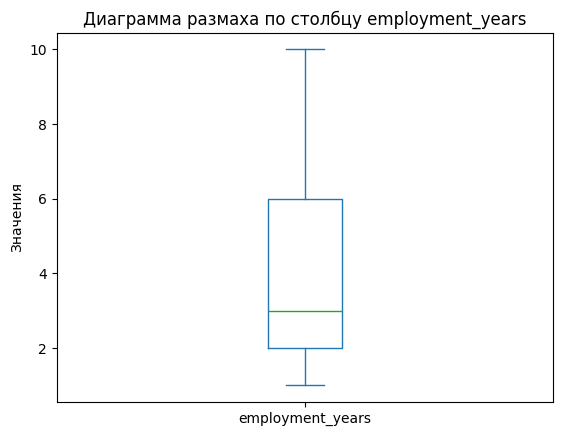

In [48]:
#строим диаграммы размаха для столбцов, где выбросы надо будет возможно удалять
df_train1['employment_years'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу employment_years', ylabel = 'Значения')
plt.show()

Выбросов нет

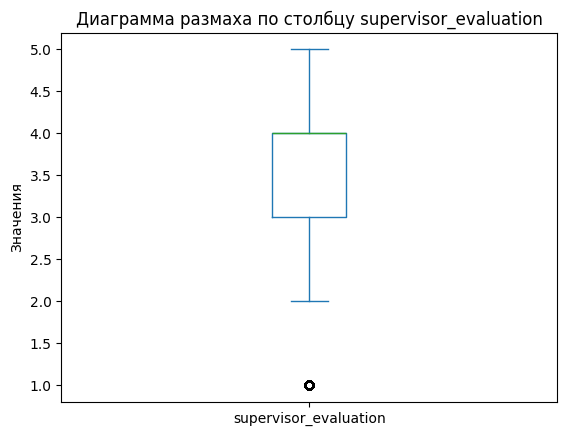

In [49]:
df_train1['supervisor_evaluation'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу supervisor_evaluation', ylabel = 'Значения')
plt.show()

Выбросы разумны, удалять не стоит.

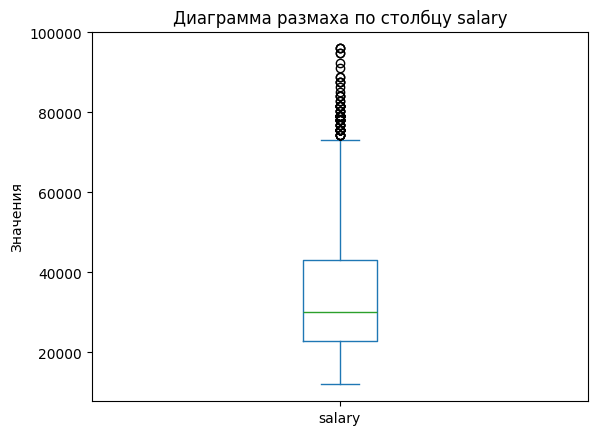

In [50]:
df_train1['salary'].plot(kind = 'box', title = 'Диаграмма размаха по столбцу salary', ylabel = 'Значения')
plt.show()

Выбросы разумны, удалять не стоит.

С данными все отлично

In [51]:
#анализируем 5 набор данных
filepath = r"C:\Users\erofe\Downloads\test_target_quit.csv"
df_y1 = pd.read_csv(filepath, sep=',')
#ищем дубликаты
print(df_y1.duplicated().sum())
#выводим первые 10 строк таблицы
print(df_y1.head(10))
#выводим информацию о таблице
print(df_y1.info())

0
       id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes
5  223063   no
6  810370   no
7  998900   no
8  578329   no
9  648850   no
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


In [52]:
print(df_y1['quit'].unique())

['yes' 'no']


С данными все отлично

### Предобработка данных

Вывод: В данной части работы предобработка данных не нужна, так как с данными все хорошо.

### Исследовательский анализ данных

Не вижу смысла анализировать еще раз, проанализированные признаки, поэтому сосредоточимся на анализе целевого признака и выпонения других целей этой части работы. 

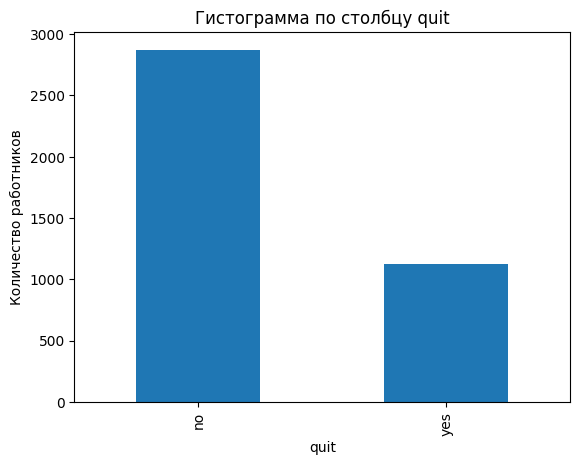

In [53]:
df_train1['quit'].value_counts().plot(kind = 'bar', title = 'Гистограмма по столбцу quit')
plt.xlabel('quit')
plt.ylabel('Количество работников')
plt.show()

Огромное количество сотрудников компании ушли в прошлом году(больше 30 процентов), это очень плохо для компании. 

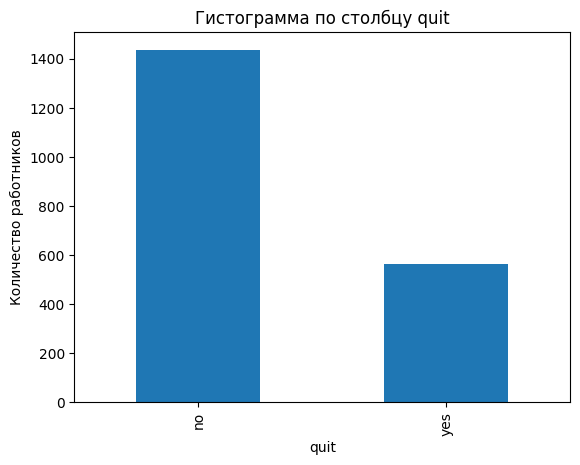

In [54]:
df_y1['quit'].value_counts().plot(kind = 'bar', title = 'Гистограмма по столбцу quit')
plt.xlabel('quit')
plt.ylabel('Количество работников')
plt.show()

Данные тестовой выборки практически не отличаются от тренировочной. 

In [55]:
#Отбираем уволившихся сотрудников
quit = df_train1.query('quit == "yes"')
quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes
...,...,...,...,...,...,...,...,...,...,...
3989,150315,purchasing,junior,low,1,no,no,2,15600,yes
3991,778735,technology,junior,low,2,no,no,4,22800,yes
3994,775320,technology,junior,high,1,no,no,4,42000,yes
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes


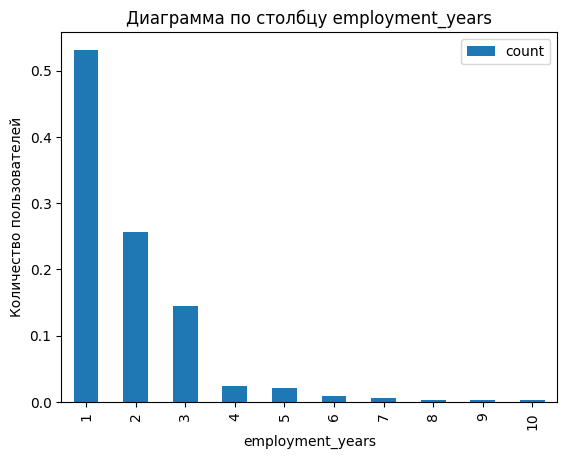

In [56]:
#Проводим анализ всех имеющихся признаков
bar_sorted = quit['employment_years'].value_counts(normalize=True).reset_index()
bar_sorted.columns = ['employment_years', 'count']
bar_sorted = bar_sorted.sort_values(by = 'employment_years')
bar_sorted.plot(kind = 'bar', x = 'employment_years', y = 'count', title = 'Диаграмма по столбцу employment_years')
plt.xlabel('employment_years')
plt.ylabel('Количество пользователей')
plt.show()

Большинство уволившихся сотрудников работали 1 год, те кто работали более 3 лет, практически не уволнялись.

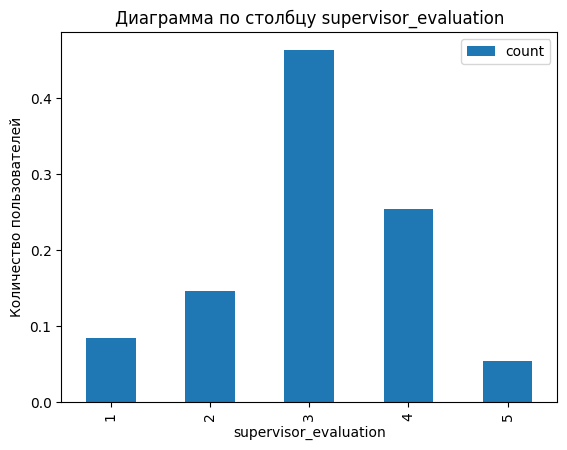

In [57]:
bar_sorted = quit['supervisor_evaluation'].value_counts(normalize=True).reset_index()
bar_sorted.columns = ['supervisor_evaluation', 'count']
bar_sorted = bar_sorted.sort_values(by = 'supervisor_evaluation')
bar_sorted.plot(kind = 'bar', x = 'supervisor_evaluation', y = 'count', title = 'Диаграмма по столбцу supervisor_evaluation')
plt.xlabel('supervisor_evaluation')
plt.ylabel('Количество пользователей')
plt.show()

В основном, те ксто уходили, работали на оценку 3, так же много людей работали на 4.

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

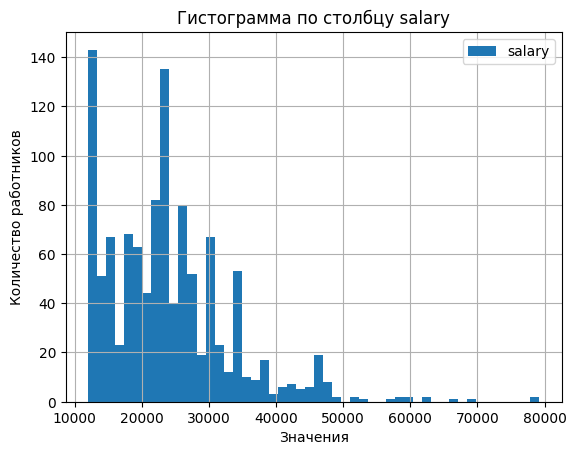

In [58]:
quit.plot(y = 'salary', kind = 'hist', bins = 50, grid=True, title = 'Гистограмма по столбцу salary')
plt.xlabel('Значения')
plt.ylabel('Количество работников')
quit['salary'].describe()

Среди ушедших, очень мало высокооплачиваемых сотрудников и средняя зарплата у них сильно меньше, чем у общей выборки.

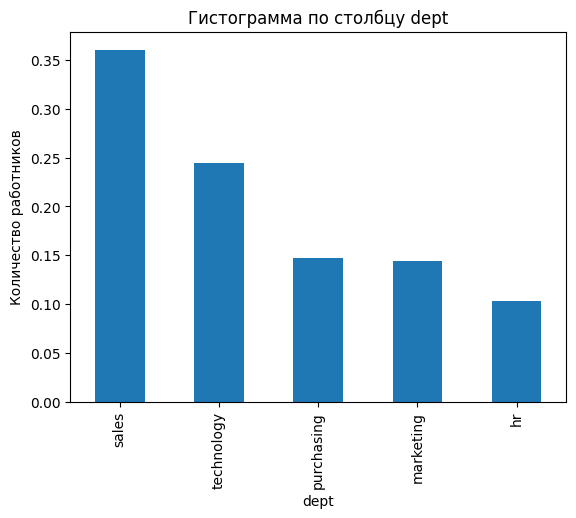

In [59]:
quit['dept'].value_counts(normalize=True).plot(kind = 'bar', title = 'Гистограмма по столбцу dept')
plt.xlabel('dept')
plt.ylabel('Количество работников')
plt.show()

Данные такие же, как и в общей выборке

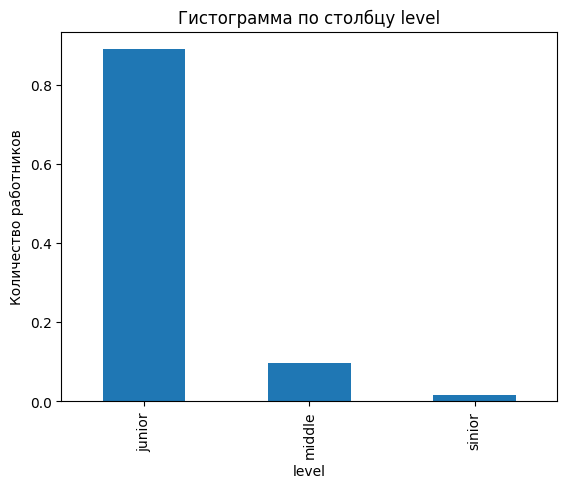

In [60]:
quit['level'].value_counts(normalize=True).plot(kind = 'bar', title = 'Гистограмма по столбцу level')
plt.xlabel('level')
plt.ylabel('Количество работников')
plt.show()

Большинство уходящих людей - джуны, что соответствует тем данным, которые мы изучали ранее.

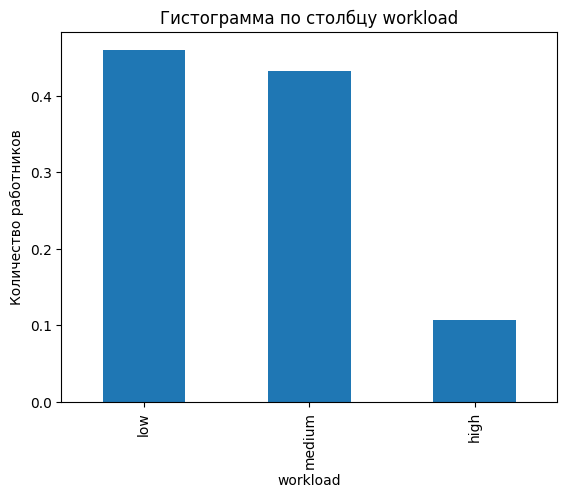

In [61]:
quit['workload'].value_counts(normalize=True).plot(kind = 'bar', title = 'Гистограмма по столбцу workload')
plt.xlabel('workload')
plt.ylabel('Количество работников')
plt.show()

В основном, уходят слабо и средне загруженные работники, что означает, что люди уходят из компании не из-за перегрузки.

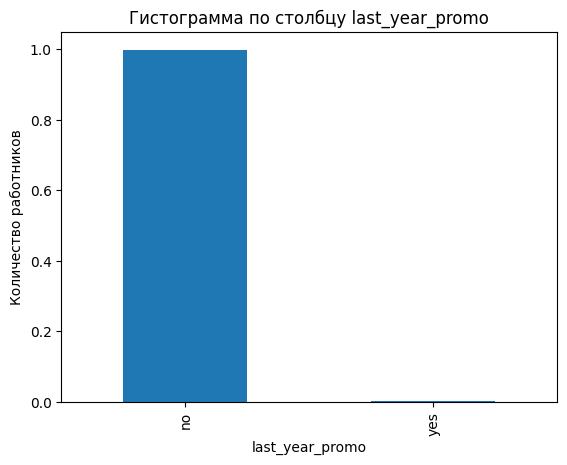

In [62]:
quit['last_year_promo'].value_counts(normalize=True).plot(kind = 'bar', title = 'Гистограмма по столбцу last_year_promo')
plt.xlabel('last_year_promo')
plt.ylabel('Количество работников')
plt.show()

Что логично, практически все ушедшие, не получали повышение в прошлом году.

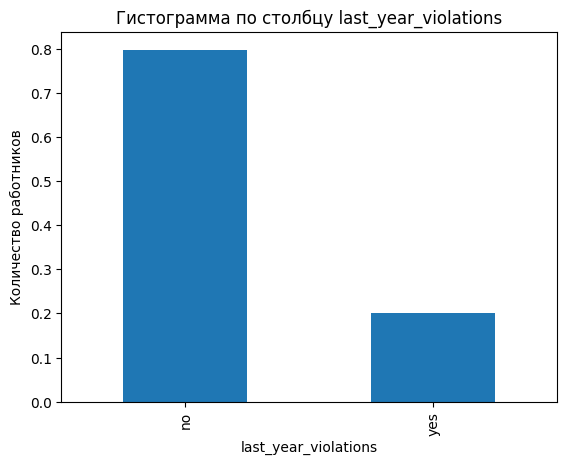

In [63]:
quit['last_year_violations'].value_counts(normalize=True).plot(kind = 'bar', title = 'Гистограмма по столбцу last_year_violations')
plt.xlabel('last_year_violations')
plt.ylabel('Количество работников')
plt.show()

Большое количество ушедших, нарушало трудовой договор, что логично, но этот процент, практически не отличается от общей выборки, что напрягает, хотя все равно больший процент ушедших не нарушало трудовой договор.

Портрет ушедшего работника:

Работал 1 год

Оценка работы - 3

Зарабатывал 24000

Работал в продажах

Был джуном

Имел низкую нагрузку

Не получал повышения

Не нарушал трудовой договор


In [64]:
#Обьединяем датафреймы для дальнейших исследований
df_y1 = df_y1.set_index('id')
df = pd.concat([df_y, df_y1], axis=1)
#Делаем выборку для построения графиков
quit_y = df.query('quit == "yes"')
no_quit_y = df.query('quit == "no"')

In [65]:
df

,job_satisfaction_rate,quit
id,,
485046,0.79,no
686555,0.72,no
467458,0.64,no
418655,0.60,no
789145,0.75,no
...,...,...
393147,0.56,yes
109582,0.14,yes
305653,0.11,yes


count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

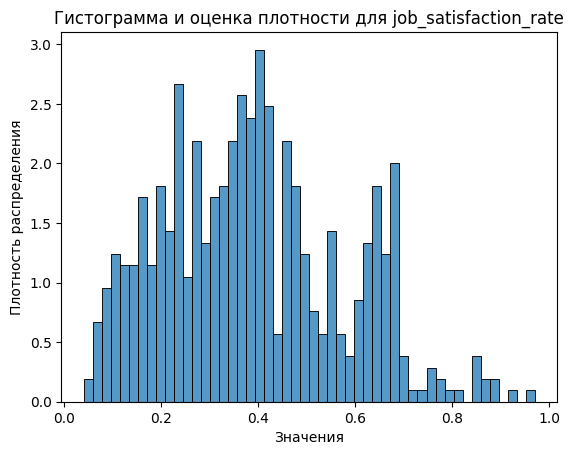

In [66]:
sns.histplot(quit_y['job_satisfaction_rate'], bins=50, kde=False, stat='density', common_norm=False)
plt.title('Гистограмма и оценка плотности для job_satisfaction_rate')
plt.xlabel('Значения')
plt.ylabel('Плотность распределения')
quit_y['job_satisfaction_rate'].describe()

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

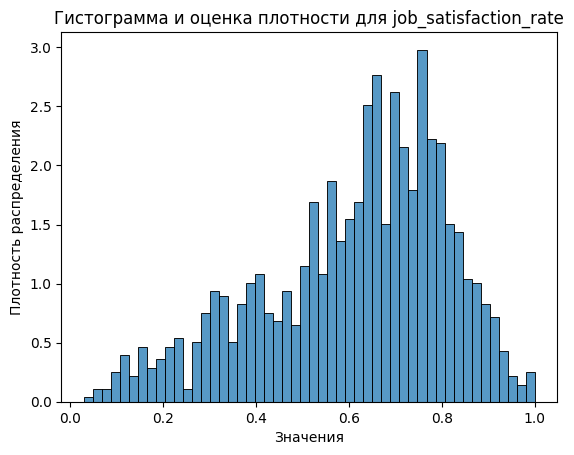

In [67]:
sns.histplot(no_quit_y['job_satisfaction_rate'], bins=50, kde=False, stat='density', common_norm=False)
plt.title('Гистограмма и оценка плотности для job_satisfaction_rate')
plt.xlabel('Значения')
plt.ylabel('Плотность распределения')
no_quit_y['job_satisfaction_rate'].describe()

По данным графикам видно, что люди, которые уходят, гораздо менее довольны своей работой, чем люди, которые остаются.

Вывод: В данной части проекта мы провели исследовательский анализ данных со всеми признаками (выводы по каждому признаку есть под графиками). Построили портрет уходящего работника и сравнили удовлетворение работой, между людьми, которые уходят и, которые остаются.

### Добавление нового входного признака

Так как к входным признакам тестовой выборки он уже добавлен, добавляем его к входным признакам тренировочной выборки

In [68]:
df_train1 = df_train1.set_index('id')
#Добавляем новый входной признак
X = df_train1.drop(['quit'], axis = 1)
y = df_train1['quit']
# Извлекаем лучшую модель Градиентного Бустинга из результатов обучения
best_model = results['GradientBoostingRegressor']['best_model']

# Извлекаем саму модель Градиентного Бустинга из составной модели (pipeline)
GradientBoostingRegressor_model = best_model.named_steps['regressor']

# Применяем предварительную обработку к новым данным для подготовки признаков перед прогнозированием
X_test_tr1 = best_model.named_steps['preprocessor'].transform(X)

# Выполняем прогноз уровня удовлетворенности работой с использованием модели Градиентного Бустинга
# Результаты добавляются в новый столбец 'job_satisfaction_rate_new' в df_train1 и округляются до двух знаков после запятой
df_train1['job_satisfaction_rate_new'] = GradientBoostingRegressor_model.predict(X_test_tr1).round(2)
df_train1

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_new
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.65
814010,sales,junior,medium,2,no,no,4,27600,no,0.83
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.40
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.31
910140,marketing,junior,medium,2,no,no,5,25200,no,0.72
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no,0.50
672059,sales,middle,high,9,no,no,4,52800,no,0.80
536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.53


In [69]:
df_x

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_new
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.82
686555,hr,junior,medium,1,no,no,4,30000,0.66
467458,sales,middle,low,5,no,no,4,19200,0.67
418655,sales,middle,low,6,no,no,4,19200,0.66
789145,hr,middle,medium,5,no,no,5,40800,0.82
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.53
109582,technology,middle,low,3,no,no,2,21600,0.15
305653,technology,junior,low,1,no,no,3,14400,0.19


Вывод: В данной части работы мы добавили к тренировочнм признаком, удовлетворенность работой, которая рассчитана по лучшей модели.

### Подготовка данных и обучение модели

In [70]:
#Строим матрицу phik
phik_matrix(df_train1, interval_cols = ['salary', 'job_satisfaction_rate_new'])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_new
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000,0.135564
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799,0.167032
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243,0.085530
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093,0.413318
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370,0.457417
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071,0.618252
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489,0.805754
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154,0.211646
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000,0.528531
job_satisfaction_rate_new,0.135564,0.167032,0.085530,0.413318,0.457417,0.618252,0.805754,0.211646,0.528531,1.000000


Мультиколлинеарности не обнаружено. Больше всего с целевым признаком коррелирует стаж работы.

In [71]:
# Разделяем данные на признаки и целевую переменную
X = df_train1.drop(['quit'], axis = 1)
y = df_train1['quit']

# Определение количественных и категориальных признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание трансформатора для категориальных данных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создание пайплайна предварительной обработки данных и поиска лучшей модели
# Для каждой модели добавим GridSearchCV для подбора гиперпараметра
models = {
    'KNeighborsClassifier': {'model': KNeighborsClassifier(), 'param_grid': {'classifier__n_neighbors': [3, 5, 7]}},
    'DecisionTreeClassifier': {'model': DecisionTreeClassifier(), 'param_grid': {'classifier__max_depth': [5, 10, 15]}},
    'LogisticRegression': {'model': LogisticRegression(), 'param_grid': {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}},
    'SVC': {'model': SVC(probability=True), 'param_grid': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}}
}

In [72]:
# Разделяем данные на признаки и целевую переменную
X = df_train1.drop(['quit'], axis = 1)
y = df_train1['quit']

# Определение количественных и категориальных признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Создание трансформатора для количественных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Создание трансформатора для категориальных данных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создание пайплайна предварительной обработки данных и поиска лучшей модели
# Для каждой модели добавим GridSearchCV для подбора гиперпараметра
models = {
    'KNeighborsClassifier': {'model': KNeighborsClassifier(), 'param_grid': {'classifier__n_neighbors': [3, 5, 7]}},
    'DecisionTreeClassifier': {'model': DecisionTreeClassifier(), 'param_grid': {'classifier__max_depth': [5, 10, 15]}},
    'LogisticRegression': {'model': LogisticRegression(), 'param_grid': {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}},
    'SVC': {'model': SVC(probability=True), 'param_grid': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}}
}

results = {}

for model_name, config in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['param_grid'], cv=5, scoring='roc_auc')
    
    # Обучение GridSearchCV
    grid_search.fit(X, y)
    
    # Вывод лучших параметров и лучшей модели
    print(f"{model_name}: Лучшие параметры - {grid_search.best_params_}")
    print(f"{model_name}: Лучшая модель - {grid_search.best_estimator_}")
    
    # Оценка точности на кросс-валидации
    roc_auc = grid_search.best_score_
    print(f"{model_name}: roc-auc на кросс-валидации - {roc_auc}\n")
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_,
        'roc_auc': roc_auc
    }

KNeighborsClassifier: Лучшие параметры - {'classifier__n_neighbors': 7}
KNeighborsClassifier: Лучшая модель - Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate_new'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                       

Я считаю, что тут надо придерживаться модели DecisionTreeClassifier, ведь у нее самая высокая метрика ROC-AUC

In [73]:
#Соединяем два датафрейма для сортировки по индексам и разделяем обратно
merged_df2 = pd.concat([df_x, df_y1], axis=1)
df_x = merged_df2.drop(['quit'], axis=1)
df_y1 = merged_df2['quit']

In [74]:
# Извлекаем лучшую модель DecisionTreeClassifier из результатов обучения
best_model = results['DecisionTreeClassifier']['best_model']

# Извлекаем саму модель DecisionTreeClassifier из составной модели (pipeline)
DecisionTreeClassifier = best_model.named_steps['classifier']

# Применяем предварительную обработку к новым данным для подготовки признаков перед прогнозированием
X_test_tr2 = best_model.named_steps['preprocessor'].transform(df_x)

# Выполняем прогноз уровня удовлетворенности работой с использованием модели DecisionTreeClassifier
# Результаты добавляются в новый столбец 'quit_new' в df_x и округляются до двух знаков после запятой

In [75]:
df_x['quit_new'] = DecisionTreeClassifier.predict_proba(X_test_tr2)[:, 1]

roc_auc1 = roc_auc_score(df_y1, df_x['quit_new'])
roc_auc1

0.9244324018649124

Вывод: В данной части работы, мы построили матрицу корреляции, определили признак, коррелирующий с целевым. Сделали пайплайн и определили, что лучшая модель - DecisionTreeClassifier. Проверили это на тестовой выборке и добавили туда новый столбец с этой моделью.

### Оформление выводов

Промежуточные выводы:

KNeighborsClassifier:

Лучшие параметры: {'classifier__n_neighbors': 7}

Лучшая модель: Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]), Index(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_new'], dtype='object')), ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object'))])), ('classifier', KNeighborsClassifier(n_neighbors=7))])

ROC-AUC на кросс-валидации: 0.9262

DecisionTreeClassifier:

Лучшие параметры: {'classifier__max_depth': 5}

Лучшая модель: Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]), Index(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_new'], dtype='object')), ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object'))])), ('classifier', DecisionTreeClassifier(max_depth=5))])

ROC-AUC на кросс-валидации: 0.9334

LogisticRegression:

Лучшие параметры: {'classifier__C': 0.1}

Лучшая модель: Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]), Index(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_new'], dtype='object')), ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object'))])), ('classifier', LogisticRegression(C=0.1))])

ROC-AUC на кросс-валидации: 0.9321

SVC:

Лучшие параметры: {'classifier__C': 10, 'classifier__kernel': 'linear'}

Лучшая модель: Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]), Index(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_new'], dtype='object')), ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object'))])), ('classifier', SVC(C=10, kernel='linear', probability=True))])

ROC-AUC на кросс-валидации: 0.9310

Промежуточные выводы:

Все модели достигли высокой точности (accuracy) на тестовом наборе данных. ROC-AUC также высок для всех моделей, указывая на хорошую способность моделей различать классы. 

Исходя из предоставленных метрик, модель DecisionTreeClassifier демонстрирует самое высокое значение ROC-AUC на кросс-валидации (0.9334), что может указывать на лучшую способность модели различать положительные и отрицательные классы.

## Общий вывод

1. Задача:

Задача состояла в построении моделей машинного обучения для прогнозирования вероятности ухода сотрудников из компании на основе предоставленных данных.

2. Этапы работы:

Исследовательский анализ данных:

Проведен обзор общей структуры данных, выявлены основные типы признаков.

Анализ распределения целевой переменной для понимания баланса классов.

Визуальный анализ связи между различными признаками.

Предварительная обработка данных:

Разделение данных на признаки и целевую переменную.

Определение количественных и категориальных признаков.

Создание трансформаторов для количественных и категориальных данных.

Использование ColumnTransformer для обработки разных типов признаков.

Построение моделей:

Модель 1:

Рассмотрены модели GradientBoostingRegressor, DecisionTreeRegressor, RandomForestRegressor и LinearRegression.

Использование GridSearchCV для подбора оптимальных гиперпараметров для каждой модели.

Оценка моделей с использованием метрики точности SMAPE.

Модель 2:

Рассмотрены модели KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC.

Использование GridSearchCV для подбора оптимальных гиперпараметров для каждой модели.

Оценка моделей с использованием метрик точности (accuracy) и ROC-AUC.

Выбор лучшей модели:

Сравнение результатов и выбор наилучшей модели на основе предоставленных метрик.

Оценка качества модели:

Оценка качества работы на тестовых данных.

3. Выводы и предложения для бизнеса:

Для бизнеса рекомендуется регулярно мониторить показатели ухода сотрудников и применять построенные модели для предсказания вероятности ухода. Это позволит компании принимать превентивные меры для удержания ценных кадров и снижения текучести персонала.

Так же рекомендуется улучшить рабочие условия для новых работников, ведь они, в основном, и не довольны условиями, из-за чего в большинстве и уходят.

Ещё стоит ввести систему бонусов для работников, ведь они, при маленькой нагрузке работают на 3, что происходит, скорее всего, из-за маленькой зарплаты и отсутствия бонусов, так их можно стимулировать к большему интересу в работе.

Возможно, стоит нагрузить новых работников, ведь большое их число работает с маленькой нагрузкой, для большой дисциплины, их стоит перевести на среднюю, но это достаточно рисковый метод, к введению этого решения стоит подходить аккуратнее.